In [1]:

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt
import numpy as np

from pytorch_lightning.loggers import WandbLogger

seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
NUM_WORKERS = 0 # int(os.cpu_count() / 2)

/dccstor/mm_hcls/shatz/miniconda3/envs/shatz_env1/lib/python3.10/site-packages/pl_bolts/utils/semi_supervised.py:15: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("sklearn", pypi_name="scikit-learn")
/dccstor/mm_hcls/shatz/miniconda3/envs/shatz_env1/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate

In [2]:
# logger=None
logger=WandbLogger(project="full_attention_3", name=None)

wandb: Currently logged in as: shatz. Use `wandb login --relogin` to force relogin


In [3]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
    drop_last=True
)


In [4]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model


class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        
        self.fe = torch.nn.Sequential(*(list(create_model().children())[:-1]))

        self.fc = nn.Sequential(nn.Linear(512, 10))
        self.C = 512 # feature dim
        self.K = 512 # number of keys in dict
        # self.queue = torch.randn((C, K))# .to(device)
        self.queue = torch.randn((self.C, self.K))# .to(device)
        # self.queue_expanded = torch.randn((BATCH_SIZE, self.C, self.K)).cuda()
        self.queue.requires_grad = False
        self.update_speed = 5


    def forward(self, x, update_queue=False):
        out = self.fe(x)
        out = torch.flatten(out, 1) # 256x512 (batchxfeats; feats=C)
#         # out_w_queue = self.cat_queue_to_out(out)
        if update_queue: self.update_queue(out.detach())
#         out = self.cat_queue_to_out(out).unsqueeze(1).cuda() # unsqueeze for C dim
#         out = self.cnn(out)
#         out = torch.flatten(out, 1)
        queue_expanded = self.queue.repeat(x.shape[0], 1, 1).cuda()
        queue_expanded.requires_grad = False
        out = torch.unsqueeze(out, 1)
        out = torch.einsum('bij,bjj->bij', out, queue_expanded)
        out = self.fc(out)
        out = torch.squeeze(out, 1)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x, update_queue=True)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        self.log("train_loss", loss)
        self.log("train_acc", acc)
        
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
    
    ### 🧪 full attention stuff ###
    def cat_queue_to_out(self, out):
        queue_block = self.queue.clone().unsqueeze(0).repeat(256, 1, 1) # make queue torch.Size([256, 512, 1280])
        out_w_queue = torch.cat((out.cpu().unsqueeze(-1), queue_block), -1) # 256x512x1281
        return out_w_queue
    
    def update_queue(self, x):
        # queue is CxK
        # need to roll by self.update_speed, then replace with curr_batch[:self.update_speed]
        new_samples = x[:self.update_speed].detach()
        self.queue = self.queue.roll(5, 1)
        self.queue[:, :self.update_speed] = new_samples.t()
#         plt.imshow(self.queue, cmap='hot', interpolation='nearest')
#         plt.show()

        

In [5]:
model = LitResnet(lr=0.05)
model.datamodule = cifar10_dm

/dccstor/mm_hcls/shatz/miniconda3/envs/shatz_env1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dccstor/mm_hcls/shatz/miniconda3/envs/shatz_env1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
model.queue.shape

torch.Size([512, 512])

In [7]:
trainer = Trainer(
    logger=logger,
    max_epochs=30,
    gpus=AVAIL_GPUS,
    callbacks=[LearningRateMonitor(logging_interval="step")],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

/dccstor/mm_hcls/shatz/miniconda3/envs/shatz_env1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | fe   | Sequential | 11.2 M
1 | fc   | Sequential | 5.1 K 
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/dccstor/mm_hcls/shatz/miniconda3/envs/shatz_env1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/dccstor/mm_hcls/shatz/miniconda3/envs/shatz_env1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/dccstor/mm_hcls/shatz/miniconda3/envs/shatz_env1/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/dccstor/mm_hcls/shatz/miniconda3/envs/shatz_env1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8605769276618958
        test_loss           0.4384969472885132
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4384969472885132, 'test_acc': 0.8605769276618958}]

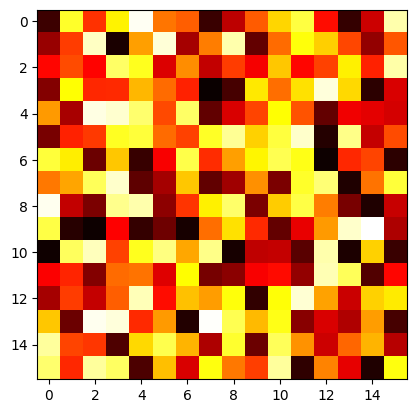

In [8]:
a = np.random.random((16, 16))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()